This notebook shows how the library can be used. 
First we read the videos, then we process them and finally we train a model

In [4]:
import mediapipe as mp
import pickle
#from app.HandHygieneMain import *
from app.HandHygieneMain import *
import time
import pandas as pd

In [ ]:
# GLOBAL VARIABLES
#PATH = r'D:\\Proyectos\\Hands\\HigieneManos' # path to folder
PATH = '/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/Videos-Epidemiologia'
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.4, min_tracking_confidence=0.4, max_num_hands = 2,static_image_mode=True) # modelo
# Model with all te functions ready to be used
#hygine_model = HandHygineModel(mp_drawing,mp_drawing_styles,mp_hands,hands)
hand_model = HandHygineModel(mp_drawing, mp_drawing_styles, mp_hands, hands, step_prediction_model=None)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
video_paths = get_videos_path(PATH)

In [4]:
video_paths

[]

In [4]:
def predict_step(succes, image, mode, pipeline, return_image=True):
    pass

In [14]:
points_array_deque = deque() # Para ir guardando datos en memoria
pasos = ['1', '2','3', '4', '5','6', '7', '8', '9', '10']
for step in pasos:
    print('va en el step: ', step)
    cap = cv2.VideoCapture('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/Videos-Epidemiologia/Paso_'+str(step)+'.MOV')
    right_hand_deque = deque() # estructura optima para ir agregando datos
    left_hand_deque = deque() 
    image_success = True
    while cap.isOpened() and image_success:
        image_success, image = cap.read()
        if not image_success:
            break
        success, _, right_hand_rows, left_hand_rows = hand_model.get_landmarks_structure(image_success, image, mode='video', return_image=False)
        # if success:
        #    cv2.imshow('Paso '+str(f[0]), image)
        # if cv2.waitKey(5) & 0xFF == 27:
        #    break

        if success: # Solo se procesan las que tienen landmarks validos 
            if hand_model.verify_hand_rows(right_hand_rows,left_hand_rows):
                right_hand_deque.append(hand_model.get_normalized_rows(right_hand_rows))
                left_hand_deque.append(hand_model.get_normalized_rows(left_hand_rows))
        
        #print('va en el step:, ', step)
        cv2.imshow('Prediccion', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1000)
    step = float(step)
    points_array = np.concatenate((np.array(right_hand_deque, dtype=float).reshape((len(right_hand_deque),-1)), 
                    np.array(left_hand_deque, dtype=float).reshape((len(left_hand_deque),-1)),
                    np.ones([len(left_hand_deque),1])*step), axis=1)
    points_array_deque.append(points_array)
print('acabo de procesar un video')


va en el step:  1
va en el step:  2
va en el step:  3
va en el step:  4
va en el step:  5
va en el step:  6
va en el step:  7
va en el step:  8
va en el step:  9
va en el step:  10
acabo de procesar un video


In [17]:
X = np.concatenate([arr for arr in points_array_deque], axis=0) # toda la informacion de los videos queda guardada ahi
X.shape

(18262, 127)

In [18]:
X = np.concatenate([arr for arr in points_array_deque], axis=0) # toda la informacion de los videos queda guardada ahi
X.shape

(18262, 127)

In [19]:
num_coords = 42
columns = []
for val in range(1, num_coords+1):
    columns += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]
columns.append('class')

df_hands = pd.DataFrame(X, columns = columns)# Guardar los resultados en un dataframe para preservarlos luego

In [16]:
PATH

'/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/Videos-Epidemiologia'

In [20]:
#df_hands.to_csv(PATH + r'\\Data\\TrainingData\\Points_04102024.csv', index=None)
df_hands.to_csv('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/HigieneManos/Data/TrainingData/Points_10102024.csv',index=None)

In [26]:
df_hands['class'].unique()

array([1. , 2.1, 2.2, 3. , 4.1, 4.2, 5.1, 5.2, 6.1, 6.2])

In [27]:
valores_unicos = [1.0, 2.1, 2.2, 3.0, 4.1, 4.2, 5.1, 5.2, 6.1, 6.2]

In [28]:
mapeo = {valor: idx + 1 for idx, valor in enumerate(valores_unicos)}
mapeo

{1.0: 1,
 2.1: 2,
 2.2: 3,
 3.0: 4,
 4.1: 5,
 4.2: 6,
 5.1: 7,
 5.2: 8,
 6.1: 9,
 6.2: 10}

In [29]:

df_hands['class'] = df_hands['class'].map(mapeo)

In [30]:
df_hands['class'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

# Model Training

Only Random Forest and LR will be used, it is immportant to evaluate the time during the inference

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump
import csv
import pickle
import tracemalloc


In [22]:
def get_model_components(model):
    '''
    Define and return the pipeline and param_grid for a given model.
    Parameters
    ----------
    model: str
        Choose the model ('lr', 'rf', 'svm') for Logistic Regression, Random Forest and Support Vector Machine, respectively.
    Returns
    -------
    pipeline : sklearn.pipeline.Pipeline
        The pipeline for the specified model.
    param_grid : dict
        The hyperparameter grid for the specified model.
    '''
    # Create pipelines with StandardScaler, Logistic Regression, and Random Forest
    # Define hyperparameter grids for GridSearchCV
    if model == 'lr':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression())
        ])
        param_grid = {
            'classifier__max_iter': [5000],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }

    elif model == 'rf':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier())
        ])
        #print(pipeline.get_params())
        param_grid = {
            'classifier__n_estimators': [5, 10, 15],
            'classifier__max_features': ['sqrt', 'log2',None],
            'classifier__max_depth': [None, 5, 10],
            'classifier__bootstrap': [False, True],
            'classifier__min_samples_leaf': [1,2,4],
            'classifier__min_samples_split': [2,5,10],
            
        }

    elif model == 'svm':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC())
        ])
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': [0.1, 1, 10],
            'classifier__degree': [2, 3, 4],
            'classifier__coef0': [0.0, 1.0, 2.0],
        }
    else:
        raise ValueError("Invalid model. Choose from 'lr', 'rf', 'svm'.")

    return pipeline, param_grid

In [23]:
def train_model(df_hands, model, version_name=''):
    '''
    Train a model between Logistic Regression, Random Forest, Super Vector Machine
    Parameters
    ----------
    path : numpy.ndarray
        file containing hand landmarks
    model: str
        Choose the model ('lr', 'rf', 'svm') for Logistic Regression, Random Forest and Support Vector Machine, respectively.
    Returns
    ----------

    '''
    X = df_hands.drop('class',axis=1)
    y = df_hands['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline, param_grid = get_model_components(model)
    # Perform GridSearchCV for the model
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs = 4)
    grid_search.fit(X_train, y_train)
    print("Best Hyperparameters for",model," are: ",  grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("\n", model, " Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Retrain the model
    best_model.fit(X,y)
    
    
    with open(str(model)+ version_name + '.pkl', 'wb') as model_file:
        pickle.dump(best_model, model_file)
    #dump(grid_search, str(model)+'.pkl')
    print(f"Model saved as {model}.pkl")
    
    return best_model


In [37]:
def measure_inference_time(model, X_test):
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    general_time = end_time - start_time

    v_times=np.zeros(X_test.shape[0], dtype=np.float64)
    v_memory=np.zeros(X_test.shape[0], dtype=np.float64)
    v_memory_peak=np.zeros(X_test.shape[0], dtype=np.float64)

    for i in range(X_test.shape[0]):
        tracemalloc.start()
        start_time = time.time()
        #model.predict(X_test[i].reshape(1, -1))
        model.predict(X_test.iloc[i:i+1])
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        v_memory[i] = current / 10**3 # Convertir a megabytes
        v_memory_peak[i] = peak / 10**3  # Convertir a megabytes
        tracemalloc.stop()
        
        # Detener el rastreo de memoria
        tracemalloc.stop()
        v_times[i] = end_time - start_time

    return general_time, v_times.mean(), v_memory.mean(), v_memory_peak.mean()

def generate_test_results(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    inference_time, individual_inference_time, individual_memory_used, max_individual_memory_used = measure_inference_time(model, X_test)
    
    # Save confusion matrix for test results
    #save_confusion_matrix(y_test, y_pred, model_name)

    test_results_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [round(accuracy_score(y_test, y_pred), 3)],
        'Precision': [round(precision_score(y_test, y_pred, average='weighted'), 3)],
        'Recall': [round(recall_score(y_test, y_pred, average='weighted'), 3)],
        'F1-Score': [round(f1_score(y_test, y_pred, average='weighted'), 3)],
        'Inference Time (seconds)': [round(inference_time, 3)], 
        'Mean Frame Inference Time (seconds)': [round(individual_inference_time, 3)], 
        'Mean Memory Used (KiloBytes)': [round(individual_memory_used, 3)], 
        'Mean Max Memory Used (KiloBytes)': [round(max_individual_memory_used, 3)], 
    })

    return test_results_df


model_files = ['Data/Models/lr_10102024.pkl', 'Data/Models/rf_10102024.pkl', 'Data/Models/svm_10102024.pkl']
models = ['LR', 'RF', 'SVM']
df_hands = pd.read_csv('Data/TrainingData/Points_10102024.csv')
y = df_hands['class']
X = df_hands.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results_df = pd.DataFrame({'True Label': y_test})
#df_hands.to_csv(PATH + r'\\Data\\TrainingData\\Points_06032024.csv', index=None)





test_results_list = []
for model_file, model_name in zip(model_files, models):
    with open(model_file, 'rb') as file:
        trained_model =pickle.load(file)
    #y_pred = trained_model.predict(X_test)
    #results_df[f'Predicted {model_name}'] = y_pred
    #y_test.append(y_test)
    #y_pred.append(y_pred)
    test_results_df = generate_test_results(trained_model, X_test, y_test, model_name)
    test_results_list.append(test_results_df)

# Concatenar resultados
#final_train_results_df = pd.concat(training_results, ignore_index=True)

#final_test_results_df = pd.concat(test_results, ignore_index=True)

# Guardar resultados en CSV

#final_train_results_df.to_csv('training_results.csv', index=False)
final_test_results_df = pd.concat(test_results_list, ignore_index=True)
final_test_results_df.to_csv('test_results_11101024.csv', index=False)

print("All test results saved.")

All test results saved.


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

# Función para cargar modelos y generar predicciones
def load_and_predict(model_file, X_test):
    with open(model_file, 'rb') as file:
        trained_model = pickle.load(file)
    y_pred = trained_model.predict(X_test)
    return y_pred

# Cargar datos
df_hands = pd.read_csv('Data/TrainingData/Points_10102024.csv')
X = df_hands.drop('class', axis=1)
y = df_hands['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Archivos de modelos y nombres de modelos
model_files = ['Data/Models/lr_10102024.pkl', 'Data/Models/rf_10102024.pkl', 'Data/Models/svm_10102024.pkl']
models = ['LR', 'RF', 'SVM']

# DataFrames para almacenar las etiquetas verdaderas y las predicciones
results_df = pd.DataFrame({'True Label': y_test})

# Generar predicciones y almacenarlas en el DataFrame
for model_file, model_name in zip(model_files, models):
    y_pred = load_and_predict(model_file, X_test)
    results_df[f'Predicted {model_name}'] = y_pred

# Función para visualizar y guardar las matrices de confusión individualmente
def save_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12, "weight": "bold"}, xticklabels=labels, yticklabels=labels)  # Ajustes para números grandes y en negrita
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')  # Ajuste para el nombre del eje x en negrita
    plt.ylabel('True', fontsize=12, fontweight='bold')  # Ajuste para el nombre del eje y en negrita
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14)
    plt.tight_layout() 
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()
    print(f"Confusion matrix saved for {model_name}.")

labels = ['Step_1','Step_2.1', 'Step_2.2', 'Step_3.0', 'Step_4.1', 'Step_4.2', 'Step_5.1', 'Step_5.2', 'Step_6.1', 'Step_6.2']
# Guardar las matrices de confusión para cada modelo
for model_name in models:
    y_pred = results_df[f'Predicted {model_name}']
    save_confusion_matrix(y_test, y_pred, model_name)

print("Matrices de confusión guardadas individualmente.")


Confusion matrix saved for LR.
Confusion matrix saved for RF.
Confusion matrix saved for SVM.
Matrices de confusión guardadas individualmente.


In [35]:
results_df

,True Label,Predicted LR,Predicted RF,Predicted SVM
4484,3.0,3.0,3.0,3.0
8360,5.0,5.0,5.0,5.0
11082,7.0,7.0,7.0,7.0
3302,2.0,2.0,2.0,2.0
8409,5.0,5.0,5.0,5.0
...,...,...,...,...
9361,6.0,6.0,6.0,6.0
12492,7.0,7.0,7.0,7.0
12366,7.0,7.0,7.0,7.0
8900,5.0,5.0,5.0,5.0


In [7]:
#df_hands = pd.read_csv(PATH + r'\\Data\\TrainingData\\Points_21012024.csv')
df_hands=pd.read_csv('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/HigieneManos/Data/TrainingData/Points_040102024.csv')

In [26]:
#best_model_rf = train_model(df_hands, "rf", version_name='_10102024')
#best_model_lr = train_model(df_hands, "lr", version_name='_10102024')
best_model_svm = train_model(df_hands, "svm", version_name='_10102024')

Best Hyperparameters for svm  are:  {'classifier__C': 0.1, 'classifier__coef0': 2.0, 'classifier__degree': 2, 'classifier__gamma': 0.1, 'classifier__kernel': 'poly'}

 svm  Results:
Accuracy: 0.9986312619764577
Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       351
         2.0       1.00      1.00      1.00       363
         3.0       1.00      1.00      1.00       354
         4.0       1.00      1.00      1.00       350
         5.0       1.00      1.00      1.00       395
         6.0       1.00      1.00      1.00       366
         7.0       1.00      1.00      1.00       365
         8.0       1.00      1.00      1.00       379
         9.0       1.00      1.00      1.00       366
        10.0       1.00      1.00      1.00       364

    accuracy                           1.00      3653
   macro avg       1.00      1.00      1.00      3653
weighted avg       1.00      1.00      1.00      3653

Model 

# Real Time

In [2]:
import warnings
from app.HandHygieneMain import *
warnings.filterwarnings("ignore")

In [3]:
MODEL_PATH = r'D:\\Proyectos\\Hands\\HigieneManos\\Data\\Models\\rf_5es_98acc.pkl'
#MODEL_PATH ='/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/HigieneManos/Data/Models/rf_260624.pkl'
#MODEL_PATH ='rf_5es_98acc.pkl'
with open(MODEL_PATH, 'rb') as file:
    modelo = pickle.load(file)


#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/ZenodoDec29-2021/ ZenodoDec29-2021/Interface_number_1/Videos/2021-06-30_09-56-19-11labots.mp4')
# Set video properties for optimal performance
cap.set(cv2.CAP_PROP_FPS, 40)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

step_id =[1,2,3,4,5,6,'No Step']
step_time =[0,0,0,0,0,0,0]
video_start_time = time.time()
last_prediction = None
y=None

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.4, min_tracking_confidence=0.4, max_num_hands = 2,static_image_mode=True) # modelo
image_success = True
hand_model = HandHygineModel(mp_drawing, mp_drawing_styles, mp_hands, hands, step_prediction_model=modelo)

tracemalloc.start()
memory_usage_before = np.zeros(dtype=np.float64)
memory_usage_after = np.zeros( dtype=np.float64)
inference_times = np.zeros(dtype=np.float64)

while cap.isOpened() and image_success:
    image_success, image = cap.read()
    success, _, right_hand_rows, left_hand_rows = hand_model.get_landmarks_structure(success=image_success, image = image, mode='capture', return_image=True)

    if success: # Solo se procesan las que tienen landmarks validos 
        if hand_model.verify_hand_rows(right_hand_rows,left_hand_rows):
            X = np.concatenate([hand_model.get_normalized_rows(right_hand_rows), hand_model.get_normalized_rows(left_hand_rows)], axis=0).reshape(42*3) 
            start_time_inference = time.time()
            current, peak = tracemalloc.get_traced_memory()
            y = hand_model.predict_hygiene_step(X.reshape(1,-1))
            end_time_inference = time.time()
            inference_time = end_time_inference - start_time_inference
            current_memory_after, peak_memory = tracemalloc.get_traced_memory()

            inference_times.append(inference_time)
            memory_usage_before.append((current) / 10**6)
            memory_usage_after.append((current_memory_after) / 10**6) 
            if y != last_prediction:
                end_time = time.time()
                duration = end_time - video_start_time
                if last_prediction is None:
                    step_time[-1] += duration
                else:
                    step_time[last_prediction]+= duration
                last_prediction =y
                video_start_time = end_time
        cv2.putText(image, f"Step: {y}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 255, 255), 2)
        cv2.imshow('Hand step clasiffication in Real Time', image)


        #cv2.putText(image, str(round(y[0],1)), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        #cv2.imshow('Paso 1', image)
    
    if cv2.waitKey(5) & 0xFF == 27:
        break
print('vector de tiempos',step_time)
cap.release()
cv2.destroyAllWindows()


NameError: name 'tracemalloc' is not defined

In [9]:
print('tiempo total', sum(step_time))

tiempo total 32.00972008705139


In [16]:
sum(inference_times) / len(inference_times)


0.0015025705843277975

In [17]:
sum(memory_usage_before) / len(memory_usage_before)


4.311667780023779

In [18]:
sum(memory_usage_after) / len(memory_usage_after)

4.31418941141498

: 

# Visual Example

In [6]:
%matplotlib widget

In [7]:
points_array_deque = deque() # Para ir guardando datos en memoria
for f in video_paths[:]:
    print(f)
    step = f[0]
    cap = cv2.VideoCapture(f[1])
    right_hand_deque = deque() # estructura optima para ir agregando datos
    left_hand_deque = deque() 
    image_success = True
    while cap.isOpened() and image_success:
        image_success, image = cap.read()
        success, _, right_hand_rows, left_hand_rows = hygine_model.get_landmarks_structure(image_success, image, mode='video', return_image=False)
        # if success:
        #    cv2.imshow('Paso '+str(f[0]), image)
        # if cv2.waitKey(5) & 0xFF == 27:
        #    break

        if success: # Solo se procesan las que tienen landmarks validos 
            if hygine_model.verify_hand_rows(right_hand_rows,left_hand_rows):
                right_hand_deque.append(hygine_model.get_normalized_rows(right_hand_rows))
                left_hand_deque.append(hygine_model.get_normalized_rows(left_hand_rows))
            
    cap.release()
    cv2.destroyAllWindows()
    points_array = np.concatenate((np.array(right_hand_deque, dtype=float).reshape((len(right_hand_deque),-1)), 
                    np.array(left_hand_deque, dtype=float).reshape((len(left_hand_deque),-1)),
                    np.ones([len(left_hand_deque),1])*step), axis=1)
    points_array_deque.append(points_array)
    break

NameError: name 'video_paths' is not defined

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import numpy as np


normalized_points = np.array(right_hand_deque)

# Create the figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial timestamp index
initial_timestamp_index = 0

# Plotting the original points for the initial timestamp
scatter = ax.scatter(normalized_points[initial_timestamp_index, :,0], 
                     normalized_points[initial_timestamp_index, :,1], 
                     normalized_points[initial_timestamp_index, :,2],
                     c='blue', label='Original Points')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Create a slider axes
ax_slider = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')

# Create a slider
slider = Slider(ax_slider, 'Timestamp', 0, normalized_points.shape[0] - 1, valinit=initial_timestamp_index, valstep=1)

# Update function for the slider
def update(val):
    timestamp_index = int(slider.val)
    
    # Update the scatter plot with the new points for the selected timestamp
    scatter._offsets3d = (normalized_points[timestamp_index, :,0],
                          normalized_points[timestamp_index, :,1],
                          normalized_points[timestamp_index, :,2])

    # Redraw the plot
    fig.canvas.draw_idle()

# Connect the slider to the update function
slider.on_changed(update)

plt.show()

NameError: name 'right_hand_deque' is not defined

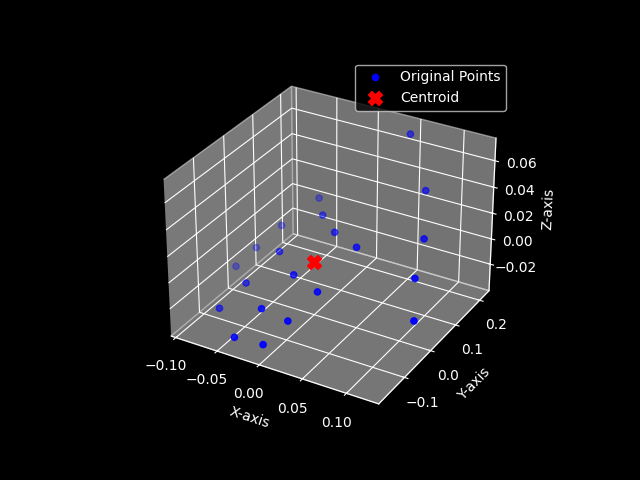

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the original points
ax.scatter(normalized_points[554,:, 0], normalized_points[554,:, 1], normalized_points[554,:, 2], c='blue', label='Original Points')

# Plotting the centroid
ax.scatter(0,0,0, c='red', marker='X', s=100, label='Centroid')

# Adding labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Display the 3D plot
plt.show()

# DB TO STORE APP DATA

In [ ]:
import sqlite3
#conn = sqlite3.connect(r'D:\Proyectos\Hands\HigieneManos\app\DataBase\HandHygiene_database.db')
conn = sqlite3.connect('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/HigieneManos/app/DataBase/HandHygiene_database.db')
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS my_table (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date_time DATETIME,
        Step_1 REAL,
        Step_2_1 REAL,
        Step_2_2 REAL,
        Step_3 REAL,
        Step_4_1 REAL,
        Step_4_2 REAL,
        Step_5_1 REAL,
        Step_5_2 REAL,
        Step_6_1 REAL,
        Step_6_2 REAL,
        No_Step REAL
    )
''')

# Confirmar los cambios
conn.commit()
conn.close()